In [3]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
import zipfile
import os

# Unzip the training set
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train_data')

# Confirm it's unzipped
print("Files in train folder:", os.listdir('/kaggle/working/train_data/train')[:5])


Files in train folder: ['cat.7002.jpg', 'cat.6218.jpg', 'cat.2869.jpg', 'dog.6238.jpg', 'cat.6688.jpg']


In [6]:
dataset_path = '/kaggle/working/train_data/train'

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_path = '/kaggle/working/train_data/train'  # Where you unzipped train.zip
base_path = '/kaggle/working/cats_vs_dogs'

# Step 1: Create directory structure
for folder in ['train/cats', 'train/dogs', 'val/cats', 'val/dogs']:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

# Step 2: Get all image filenames and corresponding labels
files = os.listdir(dataset_path)
labels = ['cats' if 'cat' in f else 'dogs' for f in files]

# Step 3: Split into train and validation sets
train_files, val_files = train_test_split(files, test_size=0.2, stratify=labels, random_state=42)

# Step 4: Move training files to train/cats or train/dogs
for f in train_files:
    label = 'cats' if 'cat' in f else 'dogs'
    src = os.path.join(dataset_path, f)
    dst = os.path.join(base_path, f'train/{label}', f)
    shutil.copy(src, dst)

# Step 5: Move validation files to val/cats or val/dogs
for f in val_files:
    label = 'cats' if 'cat' in f else 'dogs'
    src = os.path.join(dataset_path, f)
    dst = os.path.join(base_path, f'val/{label}', f)
    shutil.copy(src, dst)

print("✅ Files moved successfully.")


✅ Files moved successfully.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing and Augmentation for training set
train_gen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    horizontal_flip=True,   # Flip images randomly
    zoom_range=0.2          # Zoom in randomly
)

# Only rescaling for validation set
val_gen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_data = train_gen.flow_from_directory(
    '/kaggle/working/cats_vs_dogs/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_data = val_gen.flow_from_directory(
    '/kaggle/working/cats_vs_dogs/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751642841.299970      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751642841.300641      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(train_data, validation_data=val_data, epochs=15)
model.save('/kaggle/working/cat_dog_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1751642866.734089     120 service.cc:148] XLA service 0x796fbc004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751642866.735161     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751642866.735183     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751642867.071611     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:02:33 6s/step - accuracy: 0.4688 - loss: 0.6936

I0000 00:00:1751642870.697272     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 183ms/step - accuracy: 0.5653 - loss: 0.6855 - val_accuracy: 0.7068 - val_loss: 0.5834
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 179ms/step - accuracy: 0.6876 - loss: 0.5954 - val_accuracy: 0.6988 - val_loss: 0.5611
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 179ms/step - accuracy: 0.7227 - loss: 0.5538 - val_accuracy: 0.7700 - val_loss: 0.4912
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.7383 - loss: 0.5286 - val_accuracy: 0.7560 - val_loss: 0.4934
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 178ms/step - accuracy: 0.7485 - loss: 0.5189 - val_accuracy: 0.7654 - val_loss: 0.4812
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 179ms/step - accuracy: 0.7597 - loss: 0.4975 - val_accuracy: 0.7844 - val_loss: 0.4522
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 178ms/step - accuracy: 0.7683 - loss: 0.4889 - val_accuracy: 0.7936 - val_loss: 0.4403
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 175ms/step - accuracy: 0.7657 - loss: 0.47

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
# Load the pre-trained MobileNetV2 without the top classifier layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze feature extractor

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/tmp/ipykernel_35/2959215501.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 75, 75, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 75, 75, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 75, 75, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 75, 75, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 75, 75, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 75, 75, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 75, 75, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 75, 75, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 75, 75, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 75, 75, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 77, 77, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 38, 38, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('/kaggle/working/best_model_mobilenetv2.h5', save_best_only=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 196ms/step - accuracy: 0.8697 - loss: 0.2905 - val_accuracy: 0.9602 - val_loss: 0.1019
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.9465 - loss: 0.1365 - val_accuracy: 0.9614 - val_loss: 0.0957
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - accuracy: 0.9510 - loss: 0.1243 - val_accuracy: 0.9640 - val_loss: 0.0908
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.9575 - loss: 0.1081 - val_accuracy: 0.9644 - val_loss: 0.0860
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 193ms/step - accuracy: 0.9577 - loss: 0.1053 - val_accuracy: 0.9660 - val_loss: 0.0841
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.9615 - loss: 0.0986 - val_accuracy: 0.9622 - val_loss: 0.0914
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 189ms/step - accuracy: 0.9641 - loss: 0.0959 - val_accuracy: 0.9650 - val_loss: 0.0855
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 192ms/step - accuracy: 0.9607 -

In [16]:
# Unfreeze the last 30 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 196ms/step - accuracy: 0.8884 - loss: 0.2377 - val_accuracy: 0.9682 - val_loss: 0.0852
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9440 - loss: 0.1349 - val_accuracy: 0.9640 - val_loss: 0.0852
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.9536 - loss: 0.1184 - val_accuracy: 0.9632 - val_loss: 0.0834
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 197ms/step - accuracy: 0.9542 - loss: 0.1117 - val_accuracy: 0.9600 - val_loss: 0.0858
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 197ms/step - accuracy: 0.9592 - loss: 0.1020 - val_accuracy: 0.9686 - val_loss: 0.0753


In [17]:
model.save('/kaggle/working/final_cat_dog_model_mobilenetv2.h5')

TESTING THE MODEL

In [19]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/final_cat_dog_model_mobilenetv2.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


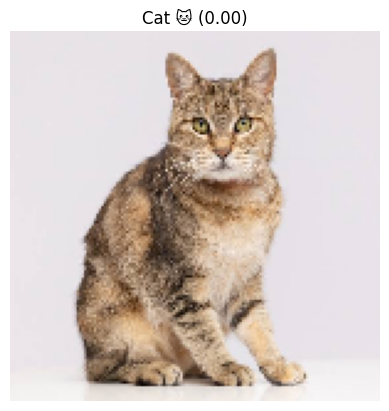

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Path to your image
img_path = '/kaggle/input/cats-uploaded/Billo Rani 01.jpeg'

# Load and preprocess image
img = load_img(img_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict using the loaded model
prediction = model.predict(img_array)[0][0]
label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"

# Display image with prediction label
plt.imshow(img)
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


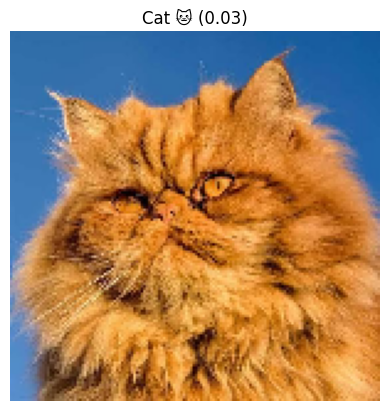

In [21]:
img_path = '/kaggle/input/cats-uploaded/Billo Rani 02.jpeg'

# Load and preprocess image
img = load_img(img_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict using the loaded model
prediction = model.predict(img_array)[0][0]
label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"

# Display image with prediction label
plt.imshow(img)
plt.title(f"{label} ({prediction:.2f})")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


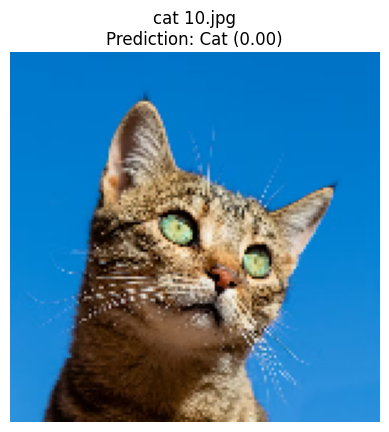

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


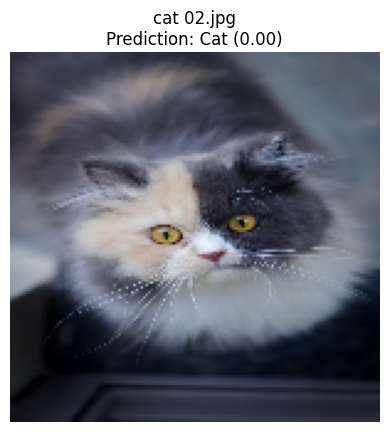

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


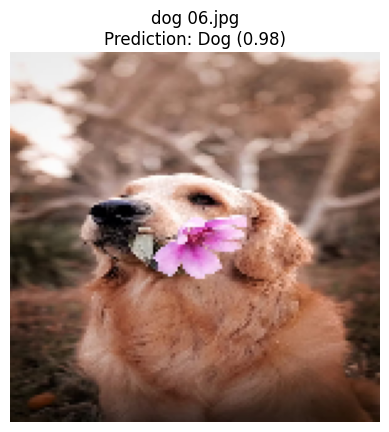

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


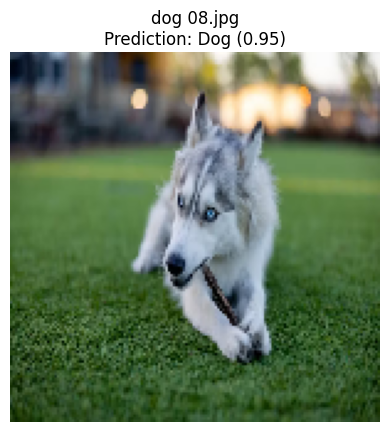

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


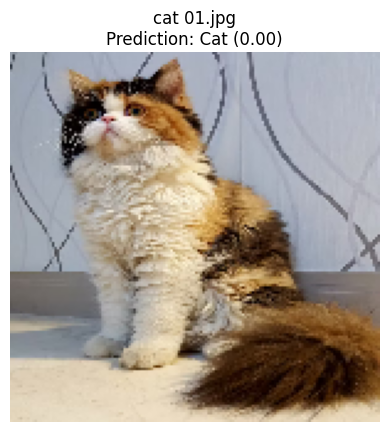

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


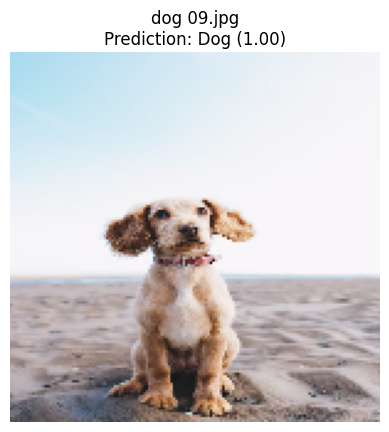

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


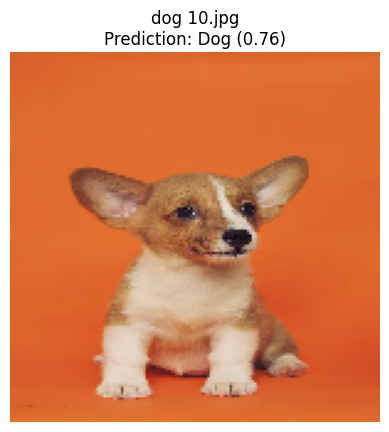

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


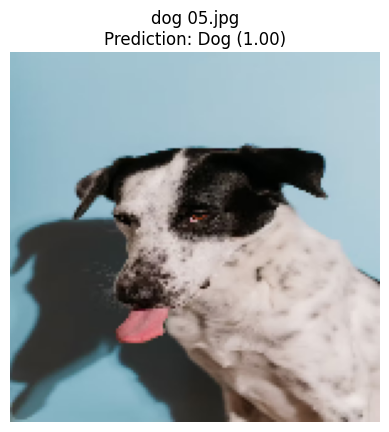

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


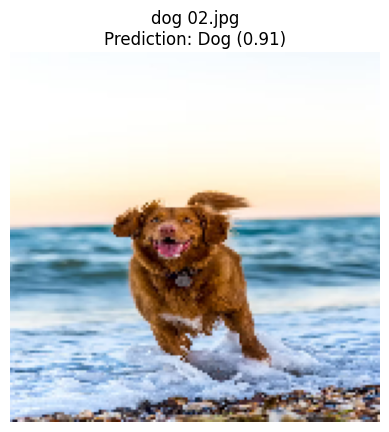

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


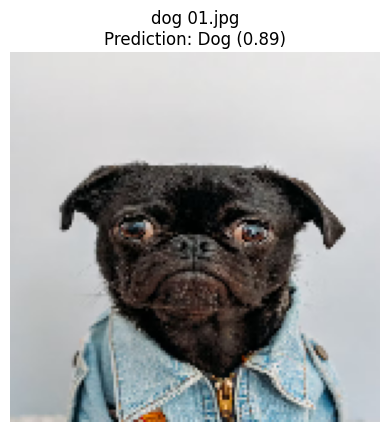

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


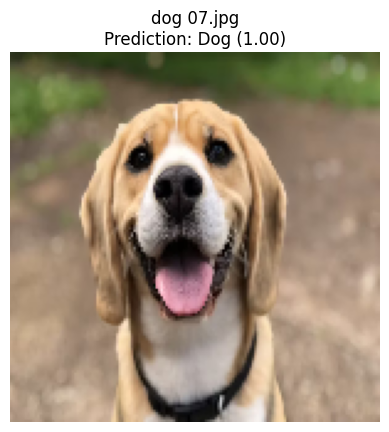

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


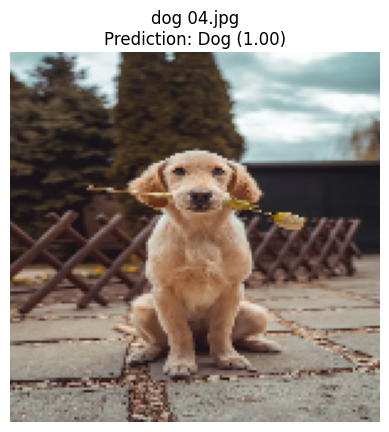

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


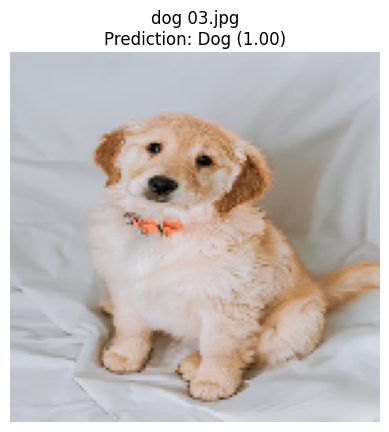

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError

# Your folder path
img_dir = '/kaggle/input/cats-uploaded'

# Supported image formats
valid_exts = ['.jpg', '.jpeg', '.png', '.bmp']

# Loop through all images in the folder
for filename in os.listdir(img_dir):
    if any(filename.lower().endswith(ext) for ext in valid_exts):
        img_path = os.path.join(img_dir, filename)
        try:
            # Load and preprocess image
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            prediction = model.predict(img_array)[0][0]
            label = "Dog" if prediction > 0.5 else "Cat"

            # Display result
            plt.imshow(img)
            plt.title(f"{filename}\nPrediction: {label} ({prediction:.2f})")
            plt.axis('off')
            plt.show()

        except UnidentifiedImageError:
            print(f"❌ Skipped {filename}: Not a valid image")
        except Exception as e:
            print(f"❌ Error loading {filename}: {e}")
